In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [32]:
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def dual_control_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

def upstream_repression_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + k2

def downstream_activation_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = activation(y[1], k2, theta2, n2) + k1

def no_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = k1 + k2

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss


In [33]:
space = [hp.uniform('k1', 1E-7, 1E-3), hp.uniform('k2', 1E-7, 1E-3), hp.uniform('theta1', 0.001, 10), hp.uniform('theta2', 0.001, 10)]

In [42]:
losses = []
def objective(param_values):
    #Integration conditions
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    #Set architecture
    ode_function = downstream_activation_sundials

    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)
    losses.append(loss)
    return loss

In [43]:
perturbed_percentages = [0.5, 0.75, 0.9, 0.95, 1, 1.05, 1.1, 1.25, 1.5]
best_params = []
best_losses = []
perturbs_list = []
for perturbation in perturbed_percentages:
    kc=12.*perturbation; km=10.*perturbation; lam=1.93E-4; Vin=1.; e0=0.0467
    best = fmin(objective, space, algo=tpe.suggest, max_evals=500)
    best_losses.append(objective(list(best.values())))
    best_params.append(best)
    perturbs_list.append(perturbation)

100%|██████████| 500/500 [00:08<00:00, 58.80trial/s, best loss: 0.05774697471185086] 


In [44]:
num_trials_data = pd.DataFrame({'perturbs': perturbs_list, 'best_losses': best_losses, 'best_params':best_params})
num_trials_data.to_csv('num_trials_data.csv')
num_trials_data = pd.read_csv('num_trials_data.csv')
k1s = []; k2s = []; theta1s = []; theta2s = []
for i in range(len(num_trials_data)):
    d = num_trials_data.best_params[i]
    k1s.append(float(d.split(',')[0].split(':')[-1]))
    k2s.append(float(d.split(',')[1].split(':')[-1]))
    theta1s.append(float(d.split(',')[2].split(':')[-1]))
    theta2s.append(float(d.split(',')[3].split(':')[-1].split('}')[0]))
num_trials_data['k1'] = k1s
num_trials_data['k2'] = k2s
num_trials_data['theta1'] = theta1s
num_trials_data['theta2'] = theta2s
num_trials_data['num_iters'] = 500
num_trials_data['circuit'] = 'Dual Control'
num_trials_data['perturbation'] = True
num_trials_data.to_csv('da_perturbs.csv')

In [64]:
da = pd.read_csv('da_10trials.csv')
da['circuit'] = 'Downstream Activation'
ur = pd.read_csv('ur_10trials.csv')
ur['circuit'] = 'Upstream Repression'
nc = pd.read_csv('nc_10trials.csv')
nc['circuit'] = 'No Control'
dc = pd.read_csv('dc_10trials.csv')
dc['circuit'] = 'Dual Control'

perturbed_dc = pd.read_csv('dc_perturbs.csv')
perturbed_da = pd.read_csv('da_perturbs.csv')
perturbed_da['circuit'] = 'Downstream Activation'
perturbed_nc = pd.read_csv('nc_perturbs.csv')
perturbed_nc['circuit'] = 'No Control'
perturbed_ur = pd.read_csv('ur_perturbs.csv')
perturbed_ur['circuit'] = 'Upstream Repression'


combined = pd.concat([da, ur, nc, dc, perturbed_dc, perturbed_da, perturbed_nc, perturbed_ur])
combined = combined.loc[combined.num_iters > 150]

features = ['k1', 'k2', 'theta1', 'theta2', 'best_losses']

x = combined.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined['pc1'] = principalComponents[:,0]
combined['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)
combined['tsne1'] = tsne_results[:,0]
combined['tsne2'] = tsne_results[:,1]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 156 samples in 0.000s...
[t-SNE] Computed neighbors for 156 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 156 / 156
[t-SNE] Mean sigma: 1.302644
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.068073
[t-SNE] KL divergence after 300 iterations: 0.332519


C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


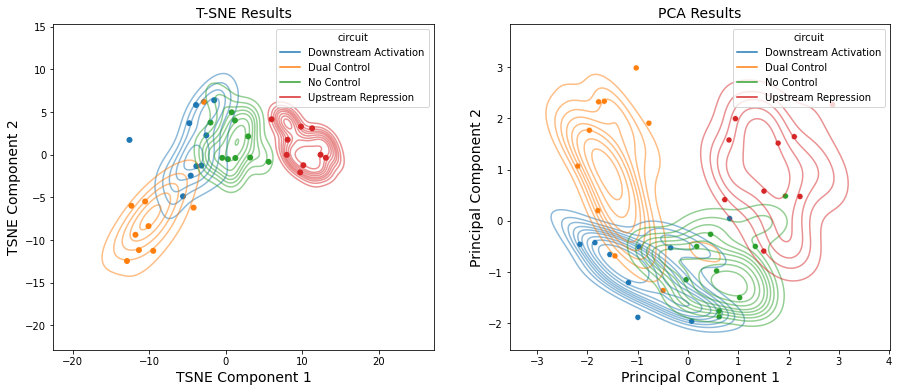

In [69]:
perturbed = combined.loc[combined.perturbation == True].sort_values(by='circuit').reset_index(drop=True)
background = combined.loc[combined.perturbation != True].sort_values(by='circuit').reset_index(drop=True)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
sns.scatterplot(x="tsne1", y="tsne2",
                hue="circuit",
                sizes=(1, 8), linewidth=0,
                data=perturbed, ax=ax)
sns.kdeplot(
    data=background,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
sns.scatterplot(x='pc1', y='pc2', data = perturbed, hue='circuit', ax=ax)
sns.kdeplot(
    data=background,
    x="pc1",
    y="pc2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.savefig('TSNE_PCA_hyperopt_perturbations.png')

In [55]:
combined

,Unnamed: 0,Unnamed: 0.1,num_iters,best_losses,best_params,k1,k2,theta1,theta2,circuit,perturbs,perturbation,pc1,pc2,tsne1,tsne2
0,0,0,500,0.075090,"{'k1': 0.0006380217266237783, 'k2': 7.92599901...",0.000638,0.000079,3.068244,9.998139,Dual Control,0.50,True,2.401260,1.546380,-83.183762,-10.397679
1,1,1,500,0.067400,"{'k1': 0.0007881574869730782, 'k2': 7.16205512...",0.000788,0.000072,2.492735,9.968046,Dual Control,0.75,True,2.579725,0.774830,47.856068,27.449703
2,2,2,500,0.065181,"{'k1': 0.00093321572182558, 'k2': 3.8254256630...",0.000933,0.000038,3.230081,9.990497,Dual Control,0.90,True,1.606897,0.888809,32.699558,-107.856461
3,3,3,500,0.064439,"{'k1': 0.000993569646349621, 'k2': 5.884638569...",0.000994,0.000059,2.054806,9.663637,Dual Control,0.95,True,2.479869,0.849609,-54.568409,94.726158
4,4,4,500,0.064851,"{'k1': 0.00021566389051794145, 'k2': 6.9076481...",0.000216,0.000069,5.127235,9.985938,Dual Control,1.00,True,1.464156,-0.785468,-9.321974,93.827835
5,5,5,500,0.063185,"{'k1': 0.0008258581374967103, 'k2': 6.08412045...",0.000826,0.000061,2.266221,9.982427,Dual Control,1.05,True,2.412755,0.304300,-23.906574,62.262718
6,6,6,500,0.064873,"{'k1': 7.067860415593741e-05, 'k2': 8.47234048...",0.000071,0.000085,9.656693,8.304208,Dual Control,1.10,True,0.648253,-1.253724,-18.688276,-56.308407
7,7,7,500,0.062206,"{'k1': 0.0005902322445211598, 'k2': 6.44072027...",0.000590,0.000064,2.495019,9.799798,Dual Control,1.25,True,2.213055,-0.295328,29.394987,94.595497
8,8,8,500,0.061412,"{'k1': 0.00014891284088864215, 'k2': 3.3876125...",0.000149,0.000034,8.987473,9.873136,Dual Control,1.50,True,-0.358575,-1.387341,-6.033765,6.525302
0,0,0,500,0.072474,"{'k1': 4.4686015760762906e-05, 'k2': 4.8444648...",0.000045,0.000048,7.989993,6.879599,Downstream Activation,0.50,True,-0.658435,0.257859,-50.941593,9.703344
